# Lecture 7 - Decision Trees and Random Forests

```{contents}
:local:
:depth: 1
```

## Learning goals

- Understand how decision trees split data for **regression** and **classification**.
- Read key hyperparameters: `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`.
- Visualize a small tree and interpret splits.
- Diagnose underfitting vs overfitting by sweeping `max_depth`.
- Train a **Random Forest** for regression and classification.
- Use **out-of-bag (OOB)** estimates, **feature importance**, and **permutation importance**.
- Build step-by-step code blocks that show intermediate arrays, DataFrame shapes, and plots - then assemble a clean end-to-end pipeline at the end.

---

## 0. Setup

In [1]:
# 0. Setup
# If you are on Colab, uncomment the next line.
# %pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="X has feature names")

# Optional chemistry bits - we will keep using the same dataset as Lectures 5 and 6
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors
except Exception as e:
    print("RDKit not available. Descriptor drawing will be skipped.")
    Chem = None

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

---

## 1. Data and descriptors

We will keep using the same CSV from earlier lectures and compute four quick descriptors: `MolWt`, `LogP`, `TPSA`, `NumRings`.

```{admonition} Tip
A small, stable feature set is perfect when the goal is learning modeling tools, not feature engineering.
```

### 1.1 Load data

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


### 1.2 Compute descriptors from SMILES

In [3]:
def calc_desc(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m)
    })

desc_df = df_raw["SMILES"].apply(calc_desc)
df = pd.concat([df_raw, desc_df], axis=1)
df.shape, df.columns.tolist()[:10]

((575, 13),
 ['Compound Name',
  'CAS',
  'SMILES',
  'Solubility_mol_per_L',
  'pKa',
  'Toxicity',
  'Melting Point',
  'Reactivity',
  'Oxidation Site',
  'MolWt'])

```{admonition} Quick check
Make sure there are no obvious NaNs in the four descriptors.
```

In [4]:
df[["MolWt","LogP","TPSA","NumRings"]].isna().sum()

MolWt       0
LogP        0
TPSA        0
NumRings    0
dtype: int64

---

## 2. Decision trees: what they do

```{admonition} Idea
A tree splits data into groups by asking questions like `MolWt <= 200.5`. Each split tries to make the target values in the child nodes more pure.
```

- **Regression tree**: uses **MSE** reduction to choose splits. Each leaf predicts the **mean** of `y` in that leaf.
- **Classification tree**: uses **Gini** or **entropy** to choose splits. Each leaf predicts the **majority class** and provides class probabilities.

Important knobs:
- `max_depth` - maximum number of split levels.
- `min_samples_split` - minimum samples to consider a split.
- `min_samples_leaf` - minimum samples in a leaf.
- `max_features` - number of features to consider at each split.

---

## 3. Tree regression - Melting Point

We start with **Melting Point** as a regression target using four descriptors as features.

### 3.1 Prepare `X` and `y`

In [5]:
feat = ["MolWt", "LogP", "TPSA", "NumRings"]
X = df[feat]
y = df["Melting Point"]

X.head(2), y.head(5)

(     MolWt    LogP  TPSA  NumRings
 0  134.178  1.7593  9.23       2.0
 1  166.223  3.2578  0.00       3.0,
 0    65.8
 1    90.0
 2    69.4
 3    65.0
 4    96.4
 Name: Melting Point, dtype: float64)

### 3.2 Split into train and test

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((460, 4), (115, 4), (460,), (115,))

### 3.3 Fit a tiny tree - depth 1 stump

In [7]:
tree_stump = DecisionTreeRegressor(max_depth=1, random_state=0)
tree_stump.fit(X_tr, y_tr)

print("Train R2:", r2_score(y_tr, tree_stump.predict(X_tr)).round(3))
print("Test  R2:", r2_score(y_te, tree_stump.predict(X_te)).round(3))
print("Feature importances:", dict(zip(feat, tree_stump.feature_importances_.round(3))))

Train R2: 0.503
Test  R2: 0.398
Feature importances: {'MolWt': 1.0, 'LogP': 0.0, 'TPSA': 0.0, 'NumRings': 0.0}


```{admonition} Look at the structure
A depth-1 tree makes exactly one split. This is easy to visualize and interpret.
```

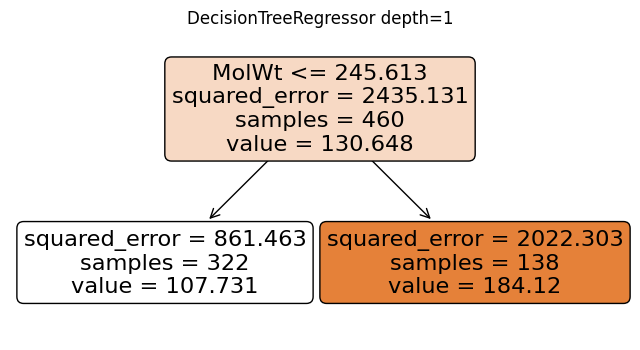

|--- MolWt <= 245.61
|   |--- value: [107.73]
|--- MolWt >  245.61
|   |--- value: [184.12]



In [8]:
plt.figure(figsize=(8,4))
plot_tree(tree_stump, feature_names=feat, filled=True, rounded=True)
plt.title("DecisionTreeRegressor depth=1")
plt.show()

print(export_text(tree_stump, feature_names=feat))

### 3.4 Increase depth step by step

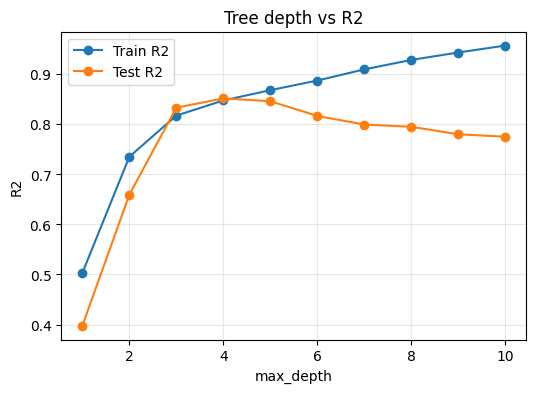

In [9]:
depths = list(range(1, 11))
r2_tr, r2_te = [], []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(X_tr, y_tr)
    r2_tr.append(r2_score(y_tr, model.predict(X_tr)))
    r2_te.append(r2_score(y_te, model.predict(X_te)))

plt.figure(figsize=(6,4))
plt.plot(depths, r2_tr, "o-", label="Train R2")
plt.plot(depths, r2_te, "o-", label="Test R2")
plt.xlabel("max_depth")
plt.ylabel("R2")
plt.title("Tree depth vs R2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{admonition} Diagnose
- Low depth - high bias.
- Very high depth - fits noise, test R2 falls.
Pick a depth that balances train and test.
```

### 3.5 Control leaves instead of depth

In [10]:
leaf_sizes = [1, 2, 5, 10, 20, 40, 80]
r2_te_leaf = []

for leaf in leaf_sizes:
    m = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=0)
    m.fit(X_tr, y_tr)
    r2_te_leaf.append(r2_score(y_te, m.predict(X_te)))

pd.DataFrame({"min_samples_leaf": leaf_sizes, "test_R2": np.round(r2_te_leaf, 3)})

,min_samples_leaf,test_R2
0,1,0.740
1,2,0.774
2,5,0.761
3,10,0.761
4,20,0.719
5,40,0.710
6,80,0.500


### 3.6 Feature importance for the chosen tree

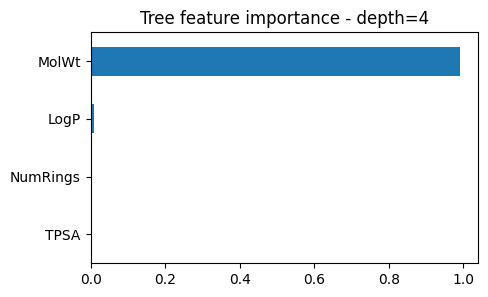

TPSA        0.00
NumRings    0.00
LogP        0.01
MolWt       0.99
dtype: float64

In [11]:
best_depth = 4
tree_best = DecisionTreeRegressor(max_depth=best_depth, random_state=0).fit(X_tr, y_tr)

imp = pd.Series(tree_best.feature_importances_, index=feat).sort_values(ascending=True)
imp.plot(kind="barh", figsize=(5,3))
plt.title(f"Tree feature importance - depth={best_depth}")
plt.show()

imp.round(3)

### 3.7 Small parity plot for the chosen tree

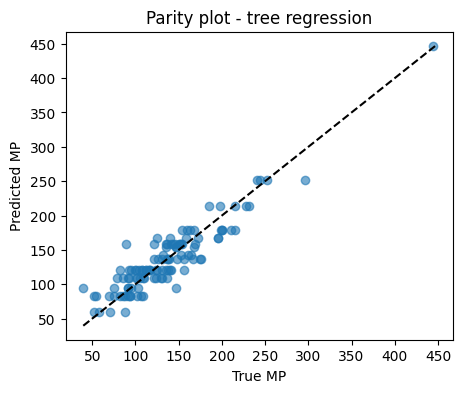

In [12]:
y_hat = tree_best.predict(X_te)
plt.figure(figsize=(5,4))
plt.scatter(y_te, y_hat, alpha=0.6)
lims = [min(y_te.min(), y_hat.min()), max(y_te.max(), y_hat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP")
plt.ylabel("Predicted MP")
plt.title("Parity plot - tree regression")
plt.show()

---

## 4. Tree classification - Toxicity

We switch to a binary label using the same descriptors.

### 4.1 Encode the labels

In [13]:
# Build a clean binary column
lab_map = {"toxic": 1, "non_toxic": 0}
y_cls = df["Toxicity"].str.lower().map(lab_map)

# Keep rows with defined labels and features
mask = y_cls.notna() & X.notna().all(axis=1)
Xc = X.loc[mask]
yc = y_cls.loc[mask].astype(int)

Xc.shape, yc.value_counts()

((575, 4),
 Toxicity
 1    474
 0    101
 Name: count, dtype: int64)

### 4.2 Stratified split

In [14]:
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)
yc_tr.mean().round(3), yc_te.mean().round(3)

(0.824, 0.826)

### 4.3 Depth 1 classifier

In [15]:
clf_stump = DecisionTreeClassifier(max_depth=1, random_state=0)
clf_stump.fit(Xc_tr, yc_tr)

yc_hat = clf_stump.predict(Xc_te)
yc_proba = clf_stump.predict_proba(Xc_te)[:,1]

print("Accuracy:", accuracy_score(yc_te, yc_hat).round(3))
print("Precision:", precision_score(yc_te, yc_hat).round(3))
print("Recall:", recall_score(yc_te, yc_hat).round(3))
print("F1:", f1_score(yc_te, yc_hat).round(3))
print("AUC:", roc_auc_score(yc_te, yc_proba).round(3))

Accuracy: 0.922
Precision: 0.939
Recall: 0.968
F1: 0.953
AUC: 0.834


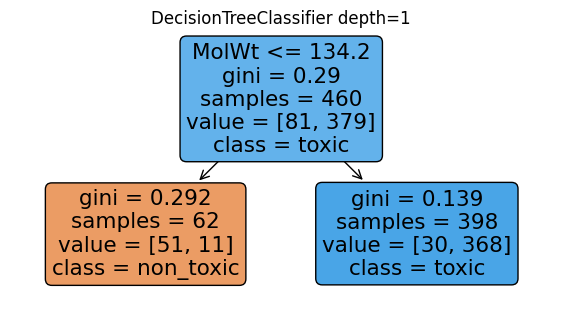

|--- MolWt <= 134.20
|   |--- class: 0
|--- MolWt >  134.20
|   |--- class: 1



In [16]:
plt.figure(figsize=(7,3.5))
plot_tree(clf_stump, feature_names=feat, class_names=["non_toxic","toxic"], filled=True, rounded=True)
plt.title("DecisionTreeClassifier depth=1")
plt.show()

print(export_text(clf_stump, feature_names=feat))

### 4.4 Sweep `max_depth` and plot scores

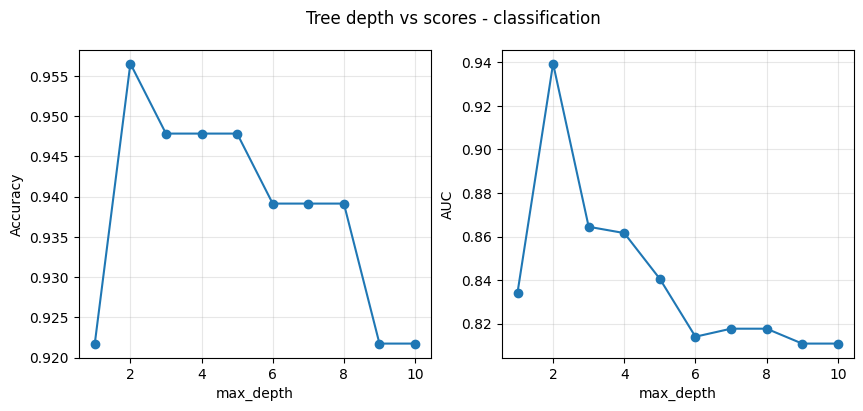

In [17]:
depths = list(range(1, 11))
accs, aucs = [], []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=0)
    m.fit(Xc_tr, yc_tr)
    proba = m.predict_proba(Xc_te)[:,1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(yc_te, pred))
    aucs.append(roc_auc_score(yc_te, proba))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(depths, accs, "o-"); ax[0].set_xlabel("max_depth"); ax[0].set_ylabel("Accuracy"); ax[0].grid(True, alpha=0.3)
ax[1].plot(depths, aucs, "o-"); ax[1].set_xlabel("max_depth"); ax[1].set_ylabel("AUC"); ax[1].grid(True, alpha=0.3)
plt.suptitle("Tree depth vs scores - classification")
plt.show()

```{admonition} Threshold reminder
Tree classifiers can output probabilities. Accuracy here uses threshold 0.5. You may re-run with different thresholds.
```

### 4.5 Confusion matrix for the chosen depth

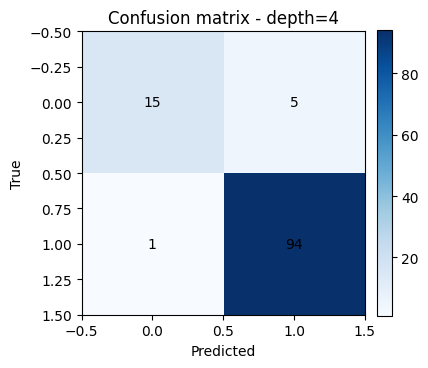

In [18]:
d_pick = 4
clf_d = DecisionTreeClassifier(max_depth=d_pick, random_state=0).fit(Xc_tr, yc_tr)
pred = clf_d.predict(Xc_te)

cm = confusion_matrix(yc_te, pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion matrix - depth={d_pick}")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

---

## 5. Random Forest - regression

A Random Forest is an **ensemble** of many trees trained on bootstrap samples. Each split considers only a subset of features. Predictions are averaged.

### 5.1 Fit the forest with OOB score

In [19]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=0,
    oob_score=True,
    n_jobs=-1,
)
rf_reg.fit(X_tr, y_tr)

print("OOB R2:", getattr(rf_reg, "oob_score_", None))
print("Test R2:", r2_score(y_te, rf_reg.predict(X_te)).round(3))

OOB R2: 0.7553165511964571
Test R2: 0.847


```{admonition} OOB
Out-of-bag samples are the rows not drawn by bootstrap for a given tree. They provide a built-in validation without a second split.
```

### 5.2 Feature importance and permutation importance

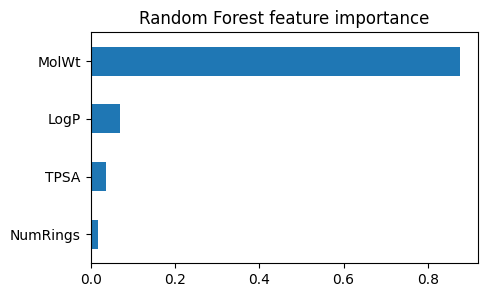

NumRings    0.019
TPSA        0.036
LogP        0.071
MolWt       0.875
dtype: float64

In [20]:
# Gini-based importance (for regression this is based on MSE reduction)
imp_rf = pd.Series(rf_reg.feature_importances_, index=feat).sort_values(ascending=True)
imp_rf.plot(kind="barh", figsize=(5,3))
plt.title("Random Forest feature importance")
plt.show()
imp_rf.round(3)

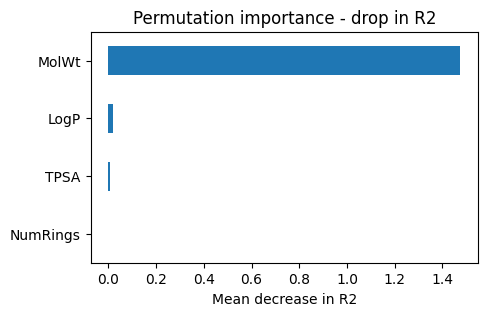

NumRings   -0.001
TPSA        0.005
LogP        0.021
MolWt       1.476
dtype: float64

In [21]:
perm = permutation_importance(rf_reg, X_te, y_te, scoring="r2", n_repeats=20, random_state=0)
perm_ser = pd.Series(perm.importances_mean, index=feat).sort_values(ascending=True)
perm_ser.plot(kind="barh", figsize=(5,3))
plt.title("Permutation importance - drop in R2")
plt.xlabel("Mean decrease in R2")
plt.show()
perm_ser.round(3)

### 5.3 Partial dependence for 1 feature

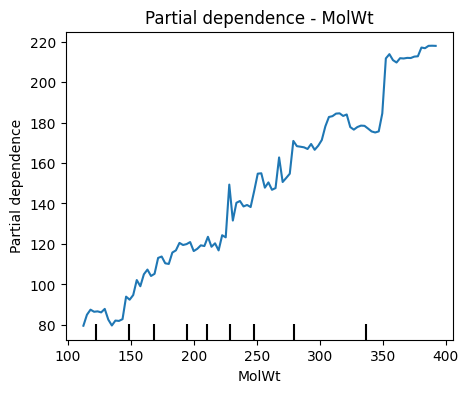

In [22]:
fig = plt.figure(figsize=(5,4))
PartialDependenceDisplay.from_estimator(rf_reg, X, ["MolWt"], ax=plt.gca())
plt.title("Partial dependence - MolWt")
plt.show()

### 5.4 Effect of `n_estimators`

In [23]:
ests = [20, 50, 100, 200, 300, 500]
r2s = []
for n in ests:
    m = RandomForestRegressor(n_estimators=n, random_state=0, n_jobs=-1)
    m.fit(X_tr, y_tr)
    r2s.append(r2_score(y_te, m.predict(X_te)))
pd.DataFrame({"n_estimators": ests, "test_R2": np.round(r2s,3)})

,n_estimators,test_R2
0,20,0.831
1,50,0.842
2,100,0.847
3,200,0.847
4,300,0.847
5,500,0.847


---

## 6. Random Forest - classification

### 6.1 Fit and report OOB score

In [24]:
rf_clf = RandomForestClassifier(
    n_estimators=400,
    random_state=0,
    oob_score=True,
    n_jobs=-1,
)
rf_clf.fit(Xc_tr, yc_tr)

print("OOB accuracy:", getattr(rf_clf, "oob_score_", None))
pred = rf_clf.predict(Xc_te)
proba = rf_clf.predict_proba(Xc_te)[:,1]
print("Test accuracy:", accuracy_score(yc_te, pred).round(3))
print("Test AUC:", roc_auc_score(yc_te, proba).round(3))

OOB accuracy: 0.9173913043478261


Test accuracy: 0.93
Test AUC: 0.981


### 6.2 ROC curve

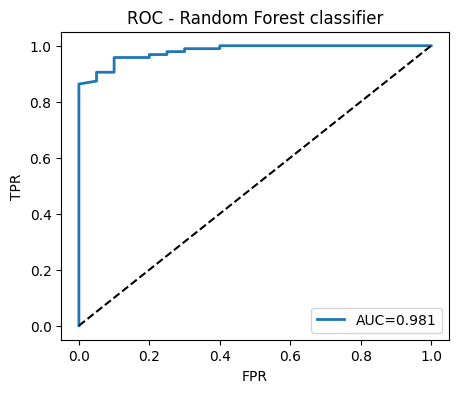

In [25]:
fpr, tpr, thr = roc_curve(yc_te, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(yc_te, proba):.3f}")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Random Forest classifier")
plt.legend()
plt.show()

### 6.3 Importance and top features

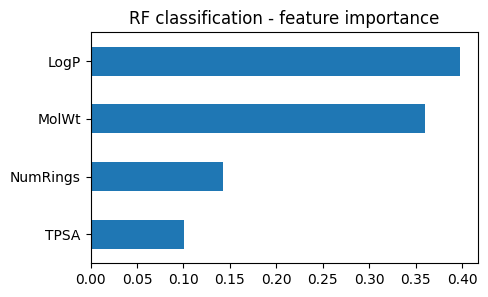

TPSA        0.100
NumRings    0.143
MolWt       0.360
LogP        0.397
dtype: float64

In [26]:
imp_rf_cls = pd.Series(rf_clf.feature_importances_, index=feat).sort_values(ascending=True)
imp_rf_cls.plot(kind="barh", figsize=(5,3))
plt.title("RF classification - feature importance")
plt.show()
imp_rf_cls.round(3)

```{admonition} Note
Tree-based importance can favor variables that can split many ways. Use permutation importance on a held-out set to cross-check.
```

In [27]:
perm_c = permutation_importance(rf_clf, Xc_te, yc_te, scoring="roc_auc", n_repeats=20, random_state=0)
pd.Series(perm_c.importances_mean, index=feat).sort_values(ascending=False).round(3)

LogP        0.137
MolWt       0.031
NumRings    0.014
TPSA        0.011
dtype: float64

---

## 7. Compare: single tree vs forest

In [28]:
tree_r = DecisionTreeRegressor(max_depth=6, random_state=0).fit(X_tr, y_tr)
rf_r   = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1).fit(X_tr, y_tr)

r2_tree = r2_score(y_te, tree_r.predict(X_te))
r2_rf   = r2_score(y_te, rf_r.predict(X_te))

print(f"Tree test R2:   {r2_tree:.3f}")
print(f"Forest test R2: {r2_rf:.3f}")

Tree test R2:   0.817
Forest test R2: 0.847


```{admonition} Why forests help
A single deep tree can overfit. Averaging many deep but varied trees reduces variance. This often boosts test performance.
```

---

## 8. Hyperparameter tuning with GridSearchCV

We will tune a small grid for each model type. Keep grids compact so the run is quick.

### 8.1 Decision tree - regression

In [29]:
param_grid_dt = {
    "max_depth": [3, 4, 5, 6, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10]
}

dt = DecisionTreeRegressor(random_state=0)
cv = KFold(n_splits=4, shuffle=True, random_state=1)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=cv, scoring="r2", n_jobs=-1)
grid_dt.fit(X_tr, y_tr)

print("Best params:", grid_dt.best_params_)
print("CV mean R2:", grid_dt.best_score_.round(3))

best_dt = grid_dt.best_estimator_
print("Test R2:", r2_score(y_te, best_dt.predict(X_te)).round(3))

Best params: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV mean R2: 0.775
Test R2: 0.845


### 8.2 Random forest - regression

In [30]:
param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["auto", "sqrt"]
}

rf = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring="r2", n_jobs=-1)
grid_rf.fit(X_tr, y_tr)

print("Best params:", grid_rf.best_params_)
print("CV mean R2:", grid_rf.best_score_.round(3))

best_rf = grid_rf.best_estimator_
print("Test R2:", r2_score(y_te, best_rf.predict(X_te)).round(3))

c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py", 

Best params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
CV mean R2: 0.774
Test R2: 0.829


### 8.3 Decision tree - classification

In [31]:
param_grid_dt_c = {
    "max_depth": [2, 3, 4, 6, None],
    "min_samples_leaf": [1, 2, 5, 10]
}

dtc = DecisionTreeClassifier(random_state=0)
cv_c = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

grid_dtc = GridSearchCV(dtc, param_grid_dt_c, cv=cv_c, scoring="roc_auc", n_jobs=-1)
grid_dtc.fit(Xc_tr, yc_tr)

print("Best params:", grid_dtc.best_params_)
print("CV mean AUC:", grid_dtc.best_score_.round(3))

best_dtc = grid_dtc.best_estimator_
print("Test AUC:", roc_auc_score(yc_te, best_dtc.predict_proba(Xc_te)[:,1]).round(3))

Best params: {'max_depth': 6, 'min_samples_leaf': 10}
CV mean AUC: 0.933
Test AUC: 0.934


### 8.4 Random forest - classification

In [32]:
param_grid_rfc = {
    "n_estimators": [200, 400],
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["auto", "sqrt"]
}

rfc = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_rfc = GridSearchCV(rfc, param_grid_rfc, cv=cv_c, scoring="roc_auc", n_jobs=-1)
grid_rfc.fit(Xc_tr, yc_tr)

print("Best params:", grid_rfc.best_params_)
print("CV mean AUC:", grid_rfc.best_score_.round(3))

best_rfc = grid_rfc.best_estimator_
proba_best = best_rfc.predict_proba(Xc_te)[:,1]
print("Test AUC:", roc_auc_score(yc_te, proba_best).round(3))

c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\users\52377\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py", 

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
CV mean AUC: 0.969
Test AUC: 0.986


---

## 9. Inspect one tree from a forest

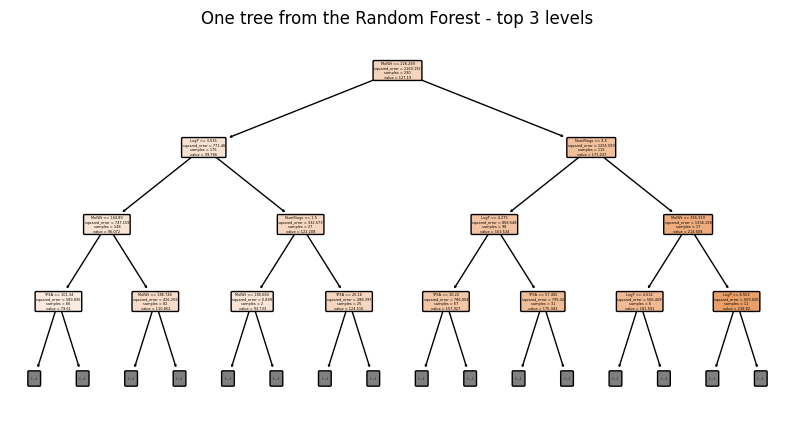

|--- MolWt <= 226.29
|   |--- LogP <= 3.54
|   |   |--- MolWt <= 144.89
|   |   |   |--- TPSA <= 101.34
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- TPSA >  101.34
|   |   |   |   |--- value: [129.90]
|   |   |--- MolWt >  144.89
|   |   |   |--- MolWt <= 186.75
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- MolWt >  186.75
|   |   |   |   |--- truncated branch of depth 3
|   |--- LogP >  3.54
|   |   |--- NumRings <= 1.50
|   |   |   |--- MolWt <= 180.68
|   |   |   |   |--- value: [92.40]
|   |   |   |--- MolWt >  180.68
|   |   |   |   |--- value: [94.40]
|   |   |--- NumRings >  1.50
|   |   |   |--- TPSA <= 26.16
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- TPSA >  26.16
|   |   |   |   |--- value: [112.10]
|--- MolWt >  226.29
|   |--- NumRings <= 4.50
|   |   |--- LogP <= 4.28
|   |   |   |--- TPSA <= 30.22
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- TPSA >  30.22
|   |   |   |   |--- truncated br

In [33]:
one_tree = best_rf.estimators_[0]
plt.figure(figsize=(10,5))
plot_tree(one_tree, feature_names=feat, filled=True, rounded=True, max_depth=3)
plt.title("One tree from the Random Forest - top 3 levels")
plt.show()

print(export_text(one_tree, feature_names=feat, max_depth=3))

```{admonition} Caution
A forest has many trees. Looking at one tree can help intuition, but the model prediction comes from the ensemble.
```

---

## 10. Putting it together - clean workflows

### 10.1 Regression pipeline - Random Forest

In [34]:
# Prepare
X = df[feat]
y = df["Melting Point"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=11)

# Fit
rf = RandomForestRegressor(n_estimators=300, random_state=11, n_jobs=-1, oob_score=True)
rf.fit(X_tr, y_tr)

# Evaluate
print("OOB R2:", getattr(rf, "oob_score_", None))
print("Test R2:", r2_score(y_te, rf.predict(X_te)).round(3))

# Predict two new points
X_new = pd.DataFrame([[135.0, 2.0, 9.2, 2],
                      [301.0, 0.5, 17.7, 2]], columns=feat)
rf.predict(X_new)

OOB R2: 0.793667801488364
Test R2: 0.757


array([ 73.21767857, 165.87166667])

### 10.2 Classification pipeline - Random Forest

In [35]:
# Prepare
lab_map = {"toxic": 1, "non_toxic": 0}
y = df["Toxicity"].str.lower().map(lab_map)
mask = y.notna() & df[feat].notna().all(axis=1)
Xc = df.loc[mask, feat]; yc = y.loc[mask].astype(int)

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.2, random_state=11, stratify=yc)

# Fit
rfc = RandomForestClassifier(n_estimators=400, random_state=11, n_jobs=-1, oob_score=True)
rfc.fit(Xc_tr, yc_tr)

# Evaluate
proba = rfc.predict_proba(Xc_te)[:,1]
pred = (proba >= 0.5).astype(int)
print("OOB accuracy:", getattr(rfc, "oob_score_", None))
print("Test accuracy:", accuracy_score(yc_te, pred).round(3))
print("Test AUC:", roc_auc_score(yc_te, proba).round(3))

OOB accuracy: 0.941304347826087
Test accuracy: 0.913
Test AUC: 0.96


---

## 11. Quick reference

```{admonition} API snippets
- Tree regression: `DecisionTreeRegressor(max_depth=..., min_samples_leaf=...).fit(X_tr, y_tr)`
- Tree classification: `DecisionTreeClassifier(...).fit(Xc_tr, yc_tr)`
- Forest regression: `RandomForestRegressor(n_estimators=..., oob_score=True)`
- Forest classification: `RandomForestClassifier(..., oob_score=True)`
- Visuals: `plot_tree(model, feature_names=feat)` and `export_text(model, feature_names=feat)`
- Importance: `model.feature_importances_` and `permutation_importance(model, X_te, y_te, ...)`
```

```{admonition} Common choices
- Start small: `max_depth=3` or `min_samples_leaf=5`.
- For forests, try `n_estimators` in `[200, 300, 500]` and `max_features="sqrt"` for classification.
- Use OOB for a quick check, still keep a proper test split.
```

---

## 12. Glossary

```{glossary}
Decision tree
  A model that recursively splits data by feature thresholds until leaves make simple predictions.

Leaf
  Final node of a tree where a prediction is made. Regression leaves predict a mean. Classification leaves predict a class distribution.

Gini
  A measure of impurity for classification. Zero means pure.

Entropy
  Another impurity measure. Zero means pure.

Out-of-bag (OOB)
  Samples left out of a bootstrap draw. A forest can score these to estimate generalization.

Feature importance
  Relative contribution of a feature to improving the split criterion across the tree or forest.

Permutation importance
  Drop in a metric when a feature is randomly shuffled on a held-out set.

max_depth
  Maximum allowed depth of the tree. Smaller limits reduce variance.

min_samples_leaf
  Minimum samples allowed in a leaf. Larger values reduce variance.

max_features
  Number of features to consider when looking for the best split. Forests often use a subset.
```

---

## 13. In-class activities

### Q1. Tree regression - sweep `min_samples_leaf`

- Use `DecisionTreeRegressor` on Melting Point with `min_samples_leaf` in `[1, 2, 5, 10, 20, 40]` and `max_depth=None`.
- Plot test R2 vs `min_samples_leaf`. Which value stabilizes test R2 without hurting it too much?

```python
# TO DO
# values = [1, 2, 5, 10, 20, 40]
# scores = []
# for v in values:
#     m = DecisionTreeRegressor(min_samples_leaf=v, random_state=0).fit(X_tr, y_tr)
#     scores.append(r2_score(y_te, m.predict(X_te)))
# plt.plot(values, scores, "o-"); plt.xscale("log")
```

### Q2. Tree classification - threshold tuning

- Train a depth-4 tree on toxicity. Scan thresholds from `0.2` to `0.8` in steps of `0.05`.
- Find the smallest threshold with recall at least `0.80`. Report precision and F1 there.

```python
# TO DO
# clf = DecisionTreeClassifier(max_depth=4, random_state=0).fit(Xc_tr, yc_tr)
# proba = clf.predict_proba(Xc_te)[:,1]
# thresholds = np.arange(0.2, 0.81, 0.05)
# ...
```

### Q3. Forest regression - n_estimators curve

- Train `RandomForestRegressor` with `n_estimators` in `[50, 100, 200, 300, 500]` and record test R2.
- Plot R2 vs `n_estimators`. Where does it level off?

```python
# TO DO
# ns = [50, 100, 200, 300, 500]
# r2s = []
# for n in ns:
#     m = RandomForestRegressor(n_estimators=n, random_state=0, n_jobs=-1).fit(X_tr, y_tr)
#     r2s.append(r2_score(y_te, m.predict(X_te)))
# plt.plot(ns, r2s, "o-")
```

### Q4. Forest classification - permutation importance

- Train `RandomForestClassifier` with `n_estimators=300` on toxicity.
- Compute permutation importance on the test split using `roc_auc` as the scorer.
- Plot the result. Which descriptor helps the most?

```python
# TO DO
# rfc = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1).fit(Xc_tr, yc_tr)
# perm = permutation_importance(rfc, Xc_te, yc_te, scoring="roc_auc", n_repeats=20, random_state=0)
# pd.Series(perm.importances_mean, index=feat).sort_values().plot(kind="barh")
```

### Q5. End-to-end challenge

- Use GridSearchCV to tune a small forest for Melting Point with the grid:
  - `n_estimators`: `[200, 300]`
  - `max_depth`: `[None, 6, 10]`
  - `min_samples_leaf`: `[1, 2, 5]`
  - `max_features`: `["auto", "sqrt"]`
- Report best params, CV mean R2, and test R2.
- Predict for three SMILES of your choice by computing descriptors first.
```